# Линейная регрессия и регуляризация (немного)

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('train.zip', compression='zip',header=0,sep=',', quotechar='"')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Первым делом нужно даты из str в время перевести 

In [4]:
df.drop('dropoff_datetime', axis=1, inplace=True)
df.sort_values(by='pickup_datetime', inplace=True)

In [5]:
train_df, test_df = df[:10**6], df[10**6:]

<AxesSubplot:>

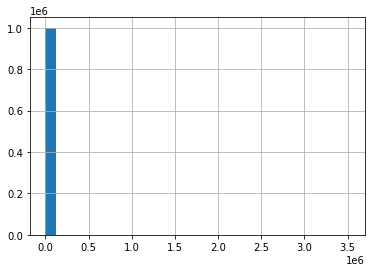

In [6]:
train_df.trip_duration.hist(bins=30)

<AxesSubplot:>

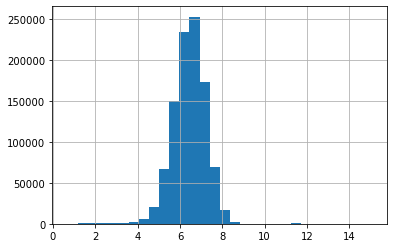

In [7]:
np.log1p(train_df.trip_duration).hist(bins=30)

С помощью логарифмирования убрали влияние выбросов 

In [8]:
train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)
test_df['log_trip_duration'] = np.log1p(test_df.trip_duration)

C:\Users\mkurs\AppData\Local\Temp/ipykernel_15280/389882633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)
C:\Users\mkurs\AppData\Local\Temp/ipykernel_15280/389882633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['log_trip_duration'] = np.log1p(test_df.trip_duration)


Теперь seaborn оможет нам графики нужные построить какие-нибудь 

In [9]:
train_df.pickup_datetime, test_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime), pd.to_datetime(test_df.pickup_datetime)

C:\Users\mkurs\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
train_df.pickup_datetime[1000] # now it is a date

Timestamp('2016-03-29 14:46:36')

In [11]:
dates = train_df.pickup_datetime.apply(lambda x: x.date())
dates

96469      2016-01-01
223872     2016-01-01
713067     2016-01-01
652463     2016-01-01
722901     2016-01-01
              ...    
1384418    2016-05-04
1100978    2016-05-04
630885     2016-05-04
567651     2016-05-04
777457     2016-05-04
Name: pickup_datetime, Length: 1000000, dtype: object

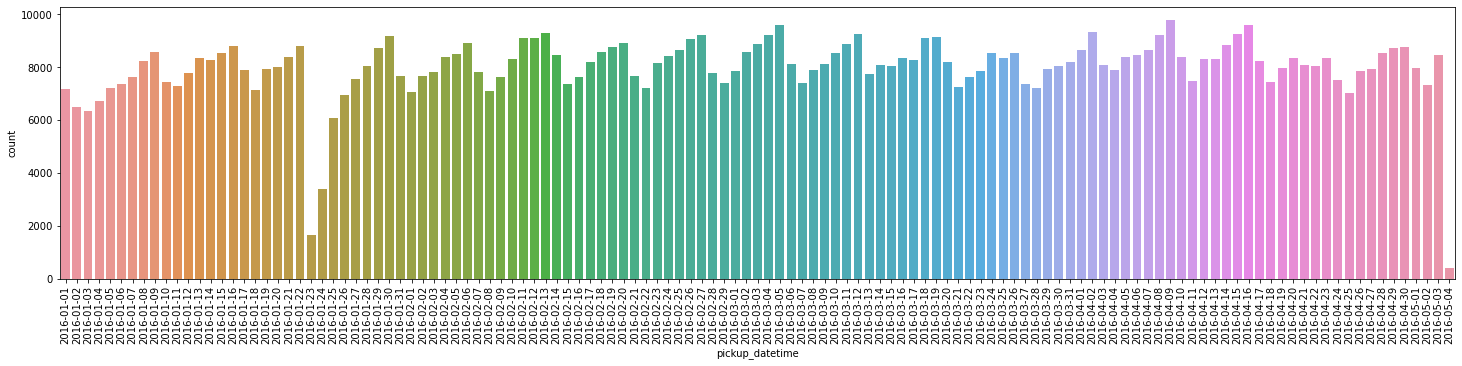

In [12]:
plt.figure(figsize=(25,5))
data_count_plot = sns.countplot(x = dates)
data_count_plot.set_xticklabels(data_count_plot.get_xticklabels(), rotation=90);

In [13]:
group_by_date = train_df.groupby(dates)

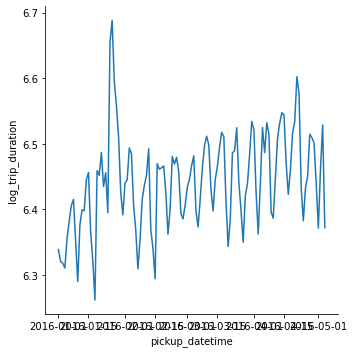

In [14]:
group_date = sns.relplot(data=group_by_date.log_trip_duration.aggregate('mean'), kind='line')

Тут есть тренд и сезонность! 

In [15]:
def create_features(data_frame):
    X = pd.concat(
        [
            data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
            data_frame.pickup_datetime.apply(lambda x: x.hour)
        ], axis=1, keys=['day', 'hour',]
    )
    return X, data_frame.log_trip_duration

In [16]:
X_train, y_train = create_features(train_df) 
X_test, y_test = create_features(test_df)

In [17]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [19]:
ohe = ColumnTransformer([('One Hot', OneHotEncoder(sparse=False), [1]),], remainder='passthrough')

In [20]:
X_train = ohe.fit_transform(X_train)

In [21]:
X_test = ohe.transform(X_test)

In [22]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [23]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [24]:
mean_squared_error(y_test, ridge.predict(X_test))

0.6539687819760845

In [25]:
ridge = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge.predict(X_test))

0.6538220444303727

Альфа оставили равным 1. Качество ухудшилось. Нужно настроить гиперпараметр

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
estim = Ridge()
param_grid = {'alpha': np.linspace(100,1000,10)}
grid_search = GridSearchCV(estim, param_grid)

In [28]:
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])})

In [29]:
grid_search.best_params_

{'alpha': 400.0}

In [30]:
mean_squared_error(y_test, grid_search.predict(X_test))

0.6538801145824537